<a href="https://colab.research.google.com/github/Mainakdeb/Wine_Quality_Prediction/blob/master/Wine_Connoisseur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
#df = pd.read_csv('./gdrive/My Drive/Wine_Quality/winequality-red.csv')

df = pd.read_csv('/content/gdrive/My Drive/Wine_Quality/winequality-red.csv')

In [0]:
split_data = df['fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'].str.split(";")

data = split_data.to_list()

names = ["Fixed_acidity", "Volatile_acidity", "Citric_acid", "Residual_sugar", "Chlorides", "Free_sulfur_dioxide", "Total_sulfur_Dioxide", "Density", "pH", "Sulphates", "Alcohol", "Quality"]

df2 = pd.DataFrame(data, columns=names)

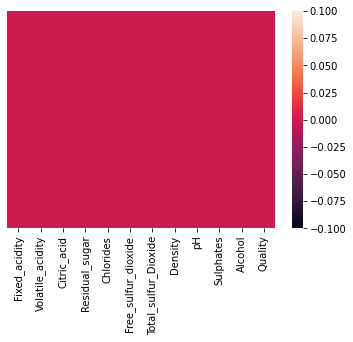

In [4]:
sn.heatmap(df2.isnull(), yticklabels=False)

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Fixed_acidity         1599 non-null   object
 1   Volatile_acidity      1599 non-null   object
 2   Citric_acid           1599 non-null   object
 3   Residual_sugar        1599 non-null   object
 4   Chlorides             1599 non-null   object
 5   Free_sulfur_dioxide   1599 non-null   object
 6   Total_sulfur_Dioxide  1599 non-null   object
 7   Density               1599 non-null   object
 8   pH                    1599 non-null   object
 9   Sulphates             1599 non-null   object
 10  Alcohol               1599 non-null   object
 11  Quality               1599 non-null   object
dtypes: object(12)
memory usage: 150.0+ KB


In [0]:
df3 = df2.astype(float)

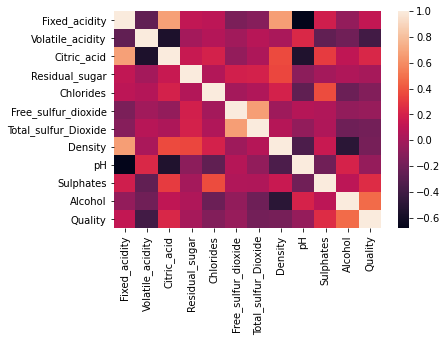

In [7]:
sn.heatmap(df3.corr())
plt.show()

In [0]:
def plot_against_attr(attribute):
    #attribute="Density"
    x = list(df3[attribute])
    y = list(df3['Quality'])
    y, x = zip(*sorted(zip(y, x)))
    plt.plot(x,y,'o')
    plt.xlabel(attribute)
    plt.xticks()
    plt.ylabel('Quality')
    plt.grid()

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.show()


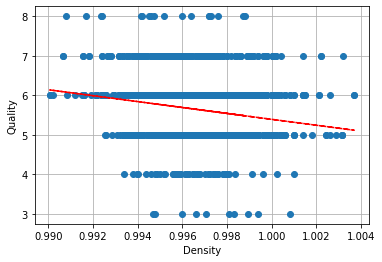

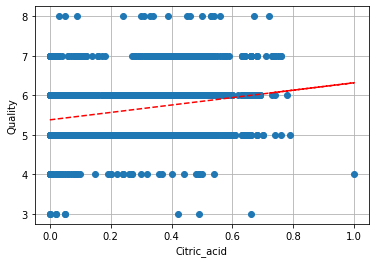

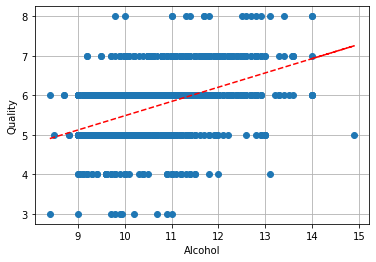

In [9]:
plot_against_attr("Density")
plot_against_attr("Citric_acid")
plot_against_attr("Alcohol")

In [0]:
# Scale

quality_backup = df3["Quality"]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df3), columns = df3.columns)
df_scaled['Quality'] = quality_backup #restore quality values

    

max_size = df_scaled['Quality'].value_counts().max()
lst = [df_scaled]
for class_index, group in df_scaled.groupby('Quality'):
    lst.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(lst)

df_scaled2=frame_new
df_scaled2["Quality"].value_counts()

#shuffle
df_scaled3=df_scaled2.sample(frac=1)

In [0]:
train = df_scaled3.iloc[:3686]
val = df_scaled3.iloc[3686:3886]
test = df_scaled3.iloc[3886:]

In [12]:
train["Quality"].value_counts()

3.0    625
5.0    616
4.0    615
8.0    615
7.0    610
6.0    605
Name: Quality, dtype: int64

In [13]:
X_train, y_train= train.drop('Quality', axis=1), train['Quality']
print(X_train.shape)

X_val, y_val = val.drop('Quality', axis=1), val['Quality']
print(X_val.shape)

X_test, y_test = test.drop("Quality", axis=1), test["Quality"]


(3686, 11)
(200, 11)


In [14]:
f=15# no. of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(X_test,f) 
test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
for i in range(len(test_label_batch)):
    test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
    
    
print(len(train_batch[0]))


246


In [0]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(11, 22)
        self.fc2 = nn.Linear(22, 44)
        self.fc3 = nn.Linear(44, 88)
        self.fc4 = nn.Linear(88, 176)
        self.fc5 = nn.Linear(176, 88)
        self.fc6 = nn.Linear(88, 22)
        self.fc7 = nn.Linear(22, 1)
       
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

model = Regressor()
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # 0.015 87
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=7) 

total_epochs=0


In [0]:

#print(model)
epochs = 1000
total_epochs+=epochs

for e in tnrange(epochs):
    
    model.train()
    train_loss = 0
    val_loss_1=0
    val_loss_sum = 0
    
    
    for i in range(len(train_batch)):
        
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
        
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_sum/len(val_batch))    
    val_losses.append(val_loss_sum/len(val_batch))    
    train_losses.append(train_loss/len(train_batch))   

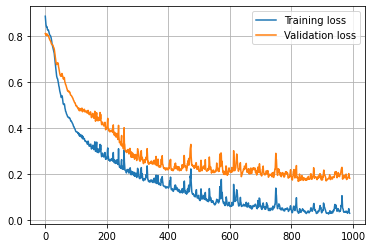

In [20]:
f=10

plt.plot(train_losses[f:], label='Training loss')
plt.plot(val_losses[f:], label='Validation loss')
plt.grid()
plt.legend()

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/Wine_Quality/model_92.pt')


In [23]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/Wine_Quality/model_92.pt'))

<All keys matched successfully>

In [24]:
correct=0
i=0
res=[]
with torch.no_grad():
    for batch in test_batch :
        for j in range(len(batch)):
            x = model(batch[j])
            #print(round(x.item()))
            res.append(round(x.item()))

true_labels= list(test["Quality"])

for i in range(len(res)):
    if res[i]==int(true_labels[i]):
        correct+=1
        
print("Accuracy:", correct/len(res))

Accuracy: 0.92
